In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from netCDF4 import Dataset
import pandas as pd
import properscoring as ps
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import warnings
import xarray as xr
# from matplotlib import cm
from utils.evaluation import find_landfalling_tcs,tc_region,create_xarray,get_storm_coords
# from utils.metrics import calculate_crps
# from global_land_mask import globe
# from scipy.interpolate import griddata
from multiprocessing import Pool
# from utils.metrics import calculate_fid
import xesmf as xe
warnings.filterwarnings("ignore")

sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))
sns.set_palette(sns.color_palette("Set2"))

In [3]:
def plot_accumulated(data,lats,lons,vmin=0,vmax=200,plot='show',cmap='Blues',title='Accumulated Rainfall',levels=[0,50,100,150,200,250,300],centre_lats=None,centre_lons=None,intensity=None):
        """
        Plots the accumulated rainfall of a tropical cyclone while it's at tropical cyclone strength
        """
        data = np.where(data<10,np.nan,data)
        lat2d,lon2d = np.meshgrid(lats,lons)
        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
        c = ax.contourf(lon2d,lat2d,data,vmin=vmin,vmax=vmax,levels=levels,cmap = cmap, transform=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
        if centre_lats is not None:
                for i in range(len(centre_lats)):
                        if intensity[i] == 0.0:
                                colour = '#ffb600'
                        elif intensity[i] == 1.0:
                                colour =  '#ff9e00'
                        elif intensity[i] == 2.0:
                                colour = '#ff7900'
                        elif intensity[i] == 3.0:       
                                colour = '#ff6000'
                        elif intensity[i] == 4.0:
                                colour = '#ff4000' 
                        elif intensity[i]==5.0:
                                colour = '#ff2000' 
                        ax.plot(centre_lons[i:i+2],centre_lats[i:i+2],color=colour)

        ax.outline_patch.set_linewidth(0.5)
        cbar = plt.colorbar(c, shrink=0.68)
        cbar.ax.tick_params(labelsize=6,width=0.5)

        if plot=='show':
                plt.show()
        else:
                plt.savefig('figs/basin_rainfall.png',bbox_inches='tight',dpi=300)

In [4]:
def find_basin_coords(basin):
	# grab mswep coordinate variables
	fp = '/bp1store/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
	ds = xr.open_dataset(fp)
	if basin == 'NA':
		min_lon = -100
		min_lat = 5
		max_lon = -30
		max_lat = 30

	mask_lon = (ds.lon >= min_lon) & (ds.lon <= max_lon)
	mask_lat = (ds.lat >= min_lat) & (ds.lat <= max_lat)
	cropped_ds = ds.where(mask_lon & mask_lat, drop=True)

	lats = cropped_ds.lat.values
	lons = cropped_ds.lon.values
	return lats,lons


In [5]:
def find_basin_tcs(meta,basin):
		"""
		Grabs all tcs that ever make landfall at tc strength

				inputs : meta csv
		"""
		nstorms,_ = meta.shape
		basin_sids = []
		if basin == 'NA':
			min_lon = -100
			min_lat = 5
			max_lon = -30
			max_lat = 30
		for i in range(nstorms):
				centre_lat = meta['centre_lat'][i]
				centre_lon = meta['centre_lon'][i]
				if centre_lon > 180:
						centre_lon = centre_lon - 180
				in_basin = (centre_lat >= min_lat) & (centre_lat <= max_lat) & (centre_lon >= min_lon) & (centre_lon <= max_lon)
				if in_basin:
						sid = meta['sid'][i]
						basin_sids.append(sid)

		# find indices of all basining snapshots
		basin_sids = list(dict.fromkeys(basin_sids))
		return basin_sids

In [6]:
mode = 'validation'
real = np.load('/user/home/al18709/work/dsrnngan_predictions/%s_real-opt.npy' % mode)[0][:,:,:,0]
pred = np.load('/user/home/al18709/work/dsrnngan_predictions/%s_pred-opt.npy' % mode)[0][:,:,:,0]
inputs = np.load('/user/home/al18709/work/dsrnngan_predictions/%s_input-opt.npy' % mode)[0][:,:,:,0]
meta = pd.read_csv('/user/work/al18709/tc_data_mswep/valid_meta.csv')
tcs = pd.read_csv('/user/work/al18709/ibtracks/tc_files.csv')

In [7]:
# define basin
basin = 'NA'
lats,lons = find_basin_coords(basin)

basin_sids = find_basin_tcs(meta,basin)
# assign sid variable to list of sid indices correspoinnding to storm timesteps
for sid in basin_sids:
	indices = meta.sid[meta.sid == sid].index.tolist()
	exec('sid_%s = indices' % sid)

all_sids = list(dict.fromkeys(meta['sid']))
print(basin_sids)
print(len(basin_sids))
print(len(all_sids))

['1986254N22309', '1996319N11283', '1981307N17279', '2010169N13266', '1989230N14338', '2018300N25315', '2001245N13326', '2006237N13298', '2000273N16277', '2005186N12299', '1999236N22292', '1989286N19268', '2005245N19315', '1989254N13340', '1988242N13262', '2018280N18273', '2015270N27291', '2014259N11262', '2003269N12322', '2012246N29323', '2010279N22293', '1985240N20286', '1984189N11265', '2001255N26276', '1983141N07269', '2006254N20306', '2017260N12310', '2011199N10271', '2017280N32321', '1992230N11325', '1992185N13265', '1982257N20291', '1993241N14264', '1998264N10343', '2010263N15328', '1988285N09318', '2011233N15301', '2007225N12331', '2005249N26281', '1992297N26299', '1989212N23270', '2005232N13263', '2004264N13328', '1996233N12340', '1991268N12264', '2005275N19274', '2005192N11318', '2020205N26272', '2005138N10265', '1994306N23313', '1995212N22287', '2008241N19303', '2016242N24279', '1995281N14278', '1995235N13311', '1995241N11333', '1984267N31302', '2020291N32305', '2011250N1232

In [34]:


# accumulated = np.zeros(grid_x.shape)
# for sid in basin_sids:
# 	print(sid)
def computation(sid):
	# initialise accumulated xarray
	grid_x, grid_y = np.meshgrid(lats, lons)
	a = np.zeros((grid_x.shape))
	accumulated_ds = create_xarray(lats,lons,a)
	accumulated_ds_pred = create_xarray(lats,lons,a)
	accumulated_ds_input = create_xarray(lats,lons,a)

	# grab mswep coordinate variables
	fp = '/bp1store/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
	d = Dataset(fp, 'r')
	lat = d.variables['lat'][:] #lat
	lon = d.variables['lon'][:] #lon
	sid = str(sid[0])
	# print('sid',sid)
	for i in globals()['sid_%s' % sid]:
		# print('i is',i)
		storm_lats,storm_lons = get_storm_coords(lat,lon,meta,i)
		ds = create_xarray(storm_lats,storm_lons,real[i])
		ds_pred = create_xarray(storm_lats,storm_lons,pred[i])
		input_lats,input_lons = get_storm_coords(np.arange(-89.5,90,1),np.arange(-179.5,180),meta,i)
		ds_input = create_xarray(input_lats,input_lons,inputs[i])

		# regrid so grids match
		regridder = xe.Regridder(ds, accumulated_ds, "nearest_s2d")
		ds_out = regridder(ds)
		ds_pred_out = regridder(ds_pred)

		# regird the inputs
		regridder = xe.Regridder(ds_input, accumulated_ds, "bilinear")
		ds_input_out = regridder(ds_input)

		# add up rainfall
		accumulated_ds = accumulated_ds + ds_out
		accumulated_ds_pred = accumulated_ds_pred + ds_pred_out
		accumulated_ds_input = accumulated_ds_input + ds_input_out
		print('sum',np.sum(accumulated_ds.precipitation.values))
		return accumulated_ds,accumulated_ds_pred,accumulated_ds_input

def process(df):
	# print('doing process...')
	res = df.apply(computation,axis=1)
	return res

if __name__ == '__main__':
	df = pd.DataFrame(basin_sids)
	df_split = np.array_split(df, len(basin_sids))
	p = Pool(processes=len(basin_sids))
	# print('pooling processes...')

	pool_results = p.map(process, df_split)
	print('results pooled')
	# result = sum(p)
	p.close()

	p.join()

sidsidsid  sid  2010169N132661984267N313021998264N103431996319N11283



i isi isi isi is    7461530811256448



sid 1992230N11325sid
i is sid9521 sid
2014259N11262
  i is2018280N182731989230N14338 

6169i isi is
  51801447

sidsid  2010279N222932011250N12324

i isi is  159326758

sidsid  2016242N242791991268N12264

i isi is  1464413226

sidsidsid  sidsid1993241N142642005186N12299  

1989212N232701992185N13265i is

sid i is 10496i is  i is
1983141N07269289811969  


95842000273N16277i is

 i is7722 2818

sidsidsidsidsid   2005249N262812004264N133281995212N22287


 i is1981307N17279i is
  sidsidi issid i issid 1231414232sidsid
sidsid1986254N22309sid   11861
  sidsidsidsidsidsidsidsidsidsidsidsidsidsidsidsidsidsidsidsidsidsid 
6692012246N293231984189N11265
    sidsidsidsidsid2018300N253151988242N13262                   2017280N32321i is


 1995241N113331985240N20286 2020205N26272 2011199N10271     
2015270N272912003269N12322
1989286N192682006254N203061989254N133402005275N192741982257N2029

In [71]:
# print(accumulated_ds)
# print(accumulated_ds_input)
# print(accumulated_ds_pred)
print(len(pool_results[0][0]))
print(len(pool_results[2][2]))
print(len(pool_results[0][0]))
print(len(pool_results[0][0][0]))

for i in range(len(pool_results)):
	accumulated_ds = accumulated_ds + pool_results[i][i][0]
	accumulated_ds_pred = accumulated_ds_pred + pool_results[i][i][1]
	accumulated_ds_input = accumulated_ds_input + pool_results[i][i][2]

print(accumulated_ds)

3
3
3
1
<xarray.Dataset>
Dimensions:        (x: 700, y: 250)
Coordinates:
    lon            (x) float32 -99.95 -99.85 -99.75 ... -30.25 -30.15 -30.05
    lat            (y) float32 5.05 5.15 5.25 5.35 ... 29.65 29.75 29.85 29.95
Dimensions without coordinates: x, y
Data variables:
    precipitation  (x, y) float64 175.5 174.0 173.6 173.4 ... 99.25 99.38 99.75


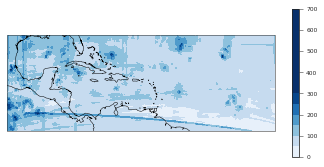

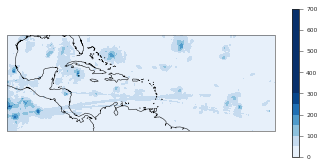

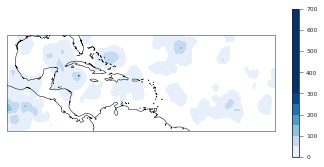

In [76]:
levels = [0,50,100,150,200,250,300,350,400,450,500,550,600,650,700]
centre_lats=None
centre_lons = None
intensity = None
plot_accumulated(accumulated_ds['precipitation'],accumulated_ds['lat'].values,accumulated_ds['lon'].values,vmin=0,vmax=300,levels = levels,plot='save',centre_lats=centre_lats,centre_lons=centre_lons,intensity=intensity)
plot_accumulated(accumulated_ds_pred['precipitation'],accumulated_ds_pred['lat'].values,accumulated_ds_pred['lon'].values,vmin=0,vmax=300,levels = levels,plot='save',centre_lats=centre_lats,centre_lons=centre_lons,intensity=intensity)
plot_accumulated(accumulated_ds_input['precipitation'],accumulated_ds_input['lat'].values,accumulated_ds_input['lon'].values,vmin=0,vmax=300,levels = levels,plot='save',centre_lats=centre_lats,centre_lons=centre_lons,intensity=intensity)



        Observations  Predicted  Low resolution
0            175.500  49.726213        8.428113
1            174.000  50.624735        8.612552
2            173.625  52.120218        8.796990
3            173.375  52.940874        8.981447
4            173.250  53.772590        9.165894
...              ...        ...             ...
174995        97.875  23.288390        0.000000
174996        98.500  23.451717        0.000000
174997        99.250  23.985566        0.000000
174998        99.375  24.056688        0.000000
174999        99.750  24.568954        0.000000

[175000 rows x 3 columns]


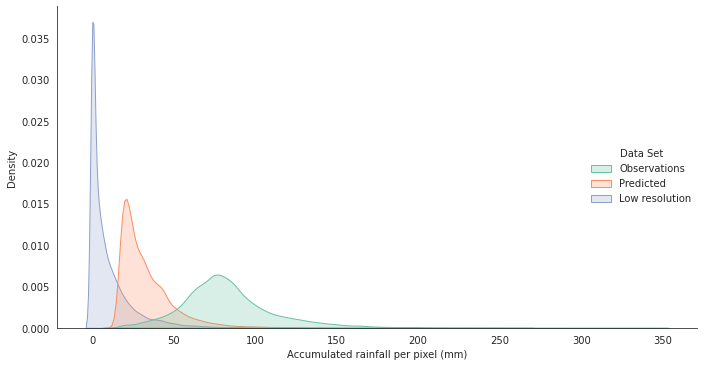

In [78]:
rain = pd.DataFrame({
	'Observations':accumulated_ds.precipitation.values.flatten(),
	'Predicted':accumulated_ds_pred.precipitation.values.flatten(),
	'Low resolution':accumulated_ds_input.precipitation.values.flatten(),

})
p = sns.displot(rain,kind="kde",fill='true',height=5, aspect=10/5)
p.set(xlabel='Accumulated rainfall per pixel (mm)')
sns.move_legend(p, "upper right", bbox_to_anchor=(.85, .6), title='Data Set')
plt.savefig('figs/accumulated_hist_basin.png',bbox_inches='tight')
# point_lat,point_lon = -82.3666, 23.1136